# Problems: 
Predicting rider retention with 6 months worth of data (January 1st to July 1st; data format type is JSON)

What fraction of the observed users were retained?

# Approach: 
Define Retention: A user is retained if "they were 'active' (i.e. took a trip) in the preceding 30 days." That is, took a trip in the month of June. A column called retained will be created as the target variable for machine learning.

Clean Data: remove rows with missing values because sufficient data survives, create datetime columns and reorder by date

Predictive Model for Retention: transform categorial variables into dummy variables for machine learning; standardize all continuous columns; models used were Random Forest and Logistic Regression; permutation importance and shap plots were used to examine feature importance.

Model validity: model was split into a train and validation set. The train set was grid-searched and cross-validated (n_folds = 5) and optimized using roc_auc. The cross-validated accuracy on the training set was 83%; The roc_auc score was 91%.

# Result:
What fraction of the observed users were retained? 41%

Predictions: The accuracy on the hold-out set was 77%; The roc_auc score was 84%.

Factors that greatly predict retention with high confidence: Going to King's Landing and being an Ultimate Black User

Concerns: avg_rating_by_driver, which I suspect is mislabled and should be "user's average rating of trip", was consistently found to be an important feature in my models, but it seems to negatively correlate with retention. Is it really possible that ratings of 5.0 lead to less retention? Are these fake ratings? As well, android users were more likely to churn which could indicate an issue with the android app if one exists (perhaps it is has far more bugs than the iphone version).

# Suggestions: 
Efforts to have all patrons visit King's Landing should be increased as it was a highly predictive factor for retention. As well, offering a discount on Ultimate Black may also keep riders as it too was a predictor of retention.

In [1]:
# required if not installed
#!pip install pydotplus
#!pip install graphviz
#!pip install eli5
#!pip install shap

In [2]:
# for data manipulation
import pandas as pd
import numpy as np
import os
import json
from collections import Counter

# For graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
from IPython.display import display, HTML, Image
import shap

# Packages for ML
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import eli5
from eli5.sklearn import PermutationImportance

# silence warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
with open("ultimate_data_challenge.json", "r") as read_file:
    data = json.load(read_file)

In [4]:
df = pd.DataFrame(data)
df.head(3)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.1,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.0,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.0,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0


# Data description

#### city: 
        city this user signed up in
#### phone: 
        primary device for this user
#### signup_date: 
        date of account registration; in the form ‘YYYYMMDD’
#### last_trip_date: 
        the last time this user completed a trip; in the form ‘YYYYMMDD’
#### avg_dist: 
        the average distance in miles per trip taken in the first 30 days after signup
#### avg_rating_by_driver: 
        the rider’s average rating over all of their trips
#### avg_rating_of_driver: 
        the rider’s average rating of their drivers over all of their trips
#### surge_pct: 
        the percent of trips taken with surge multiplier > 1
#### avg_surge: 
        The average surge multiplier over all of this user’s trips
#### trips_in_first_30_days: 
        the number of trips this user took in the first 30 days after signing up
#### ultimate_black_user: 
        TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
#### weekday_pct: 
        the percent of the user’s trips occurring during a weekday 

In [5]:
""" 
the avg_rating_by_driver seems incorrectly labeled; 
should be avg_rating_of_trip ("by rider" would be redundant since this is all user data).
however, it is possible that the driver gave the rider a rating, but this seems unlikely. 
analysis later on also suggests this column reflects how the user rated their trip
"""

# shorten other column names for readability and utility
df = df.rename(columns={"avg_rating_by_driver" : "avg_trip_rating",
                        "avg_rating_of_driver" : "avg_driver_rating",
                        "ultimate_black_user" : "ult_user",
                        "trips_in_first_30_days" : "trips_in_1st_30d"
                       })

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                 50000 non-null object
trips_in_1st_30d     50000 non-null int64
signup_date          50000 non-null object
avg_driver_rating    41878 non-null float64
avg_surge            50000 non-null float64
last_trip_date       50000 non-null object
phone                49604 non-null object
surge_pct            50000 non-null float64
ult_user             50000 non-null bool
weekday_pct          50000 non-null float64
avg_dist             50000 non-null float64
avg_trip_rating      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


# there are missing values for avg ratings and phones; over 1,000 rows survive for analysis even if all missing data points are dropped, therefore drop all missing rows with missing values; I do not impute values as I do not want to destroy correlation

In [7]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 12 columns):
city                 41445 non-null object
trips_in_1st_30d     41445 non-null int64
signup_date          41445 non-null object
avg_driver_rating    41445 non-null float64
avg_surge            41445 non-null float64
last_trip_date       41445 non-null object
phone                41445 non-null object
surge_pct            41445 non-null float64
ult_user             41445 non-null bool
weekday_pct          41445 non-null float64
avg_dist             41445 non-null float64
avg_trip_rating      41445 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.8+ MB


# transform dates to datetime type

In [8]:
df.signup_date = pd.to_datetime(df.signup_date, infer_datetime_format=True)
df.last_trip_date = pd.to_datetime(df.last_trip_date, infer_datetime_format=True)
df.info()
# results of the inferred datetime were verified for accuracy with the original dates

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 12 columns):
city                 41445 non-null object
trips_in_1st_30d     41445 non-null int64
signup_date          41445 non-null datetime64[ns]
avg_driver_rating    41445 non-null float64
avg_surge            41445 non-null float64
last_trip_date       41445 non-null datetime64[ns]
phone                41445 non-null object
surge_pct            41445 non-null float64
ult_user             41445 non-null bool
weekday_pct          41445 non-null float64
avg_dist             41445 non-null float64
avg_trip_rating      41445 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 3.8+ MB


### move dates and categorical features to beginning of df to use iloc later

In [9]:
df = df[['signup_date', 'last_trip_date', 'city', 'phone', 'ult_user'] + 
        [cols for cols in df if cols not in ['signup_date', 'last_trip_date', 'city', 'phone', 'ult_user']]]

In [10]:
df.head(1)

,signup_date,last_trip_date,city,phone,ult_user,trips_in_1st_30d,avg_driver_rating,avg_surge,surge_pct,weekday_pct,avg_dist,avg_trip_rating
0,2014-01-25,2014-06-17,King's Landing,iPhone,True,4,4.7,1.1,15.4,46.2,3.67,5.0


In [11]:
df.sort_values(by = 'signup_date').signup_date.head(3)

19810   2014-01-01
15088   2014-01-01
31834   2014-01-01
Name: signup_date, dtype: datetime64[ns]

In [12]:
df.sort_values(by = 'last_trip_date').last_trip_date.tail(3)

3397    2014-07-01
21753   2014-07-01
31481   2014-07-01
Name: last_trip_date, dtype: datetime64[ns]

# create retained user 
# assumption from instructions: user was retained if they've taken a trip within the last 30 days of the final date found in the last_trip_date, i.e. if they had a trip in June

In [13]:
df["last_month"] = df.last_trip_date.map(lambda x: int(x.strftime('%m')))
df["retained"] = df["last_month"]  >= 6
df[["last_trip_date", "last_month", "retained"]].head(10)
# to verify both created columns reflect accurate information

,last_trip_date,last_month,retained
0,2014-06-17,6,True
1,2014-05-05,5,False
2,2014-01-07,1,False
3,2014-06-29,6,True
4,2014-03-15,3,False
5,2014-06-06,6,True
7,2014-01-29,1,False
8,2014-02-01,2,False
10,2014-05-30,5,False
11,2014-01-10,1,False


# what fraction of the observed users were retained?

In [14]:
print("fraction of users retained:", round(len(df[df.retained == True])/len(df),2))

fraction of users retained: 0.41


# 41% of users are retained. This percent also reveals that the data is relatively balanced between retained and not retained

# visualize last trip months 
#### (signup months are only for January so no need for visualization)

In [15]:
# For Aesthetics
font = {'size' : 24}
mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = (12.0, 6.0) ### (→ , ↑) ###

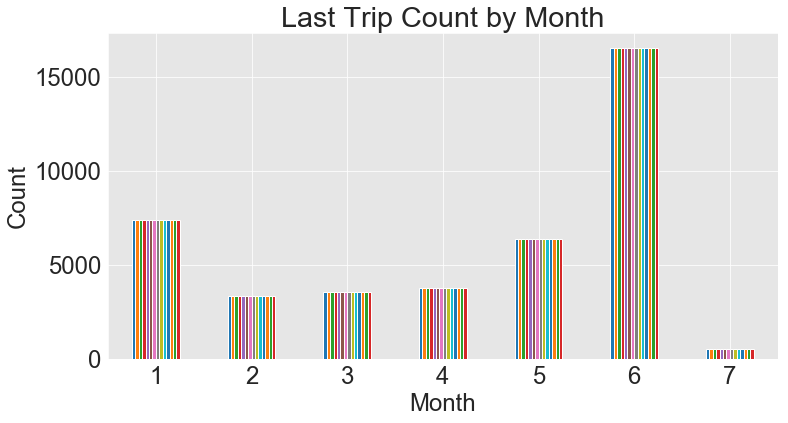

In [16]:
# by month
ax = df.groupby(df.last_trip_date.dt.month).count().plot(kind="bar")

ax.legend_ = None

plt.xticks(rotation=0)
plt.ylabel("Count")
plt.xlabel("Month")
plt.title("Last Trip Count by Month")
plt.show()

# results in line with statistical data found above

# visualize categorical features

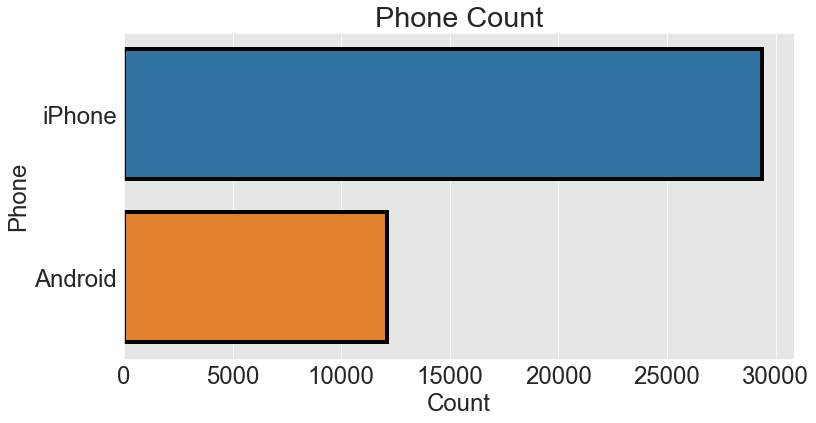

In [17]:
def count_plot(column):
    ax = sns.countplot(y = df[column], 
                  edgecolor = "black", 
                  linewidth = 4, 
                  order=df[column].value_counts().index)
    ax.set(xlabel="Count", 
           ylabel=column.capitalize())
    plt.title(column.capitalize() + " Count")
    plt.show()
    
count_plot("phone")

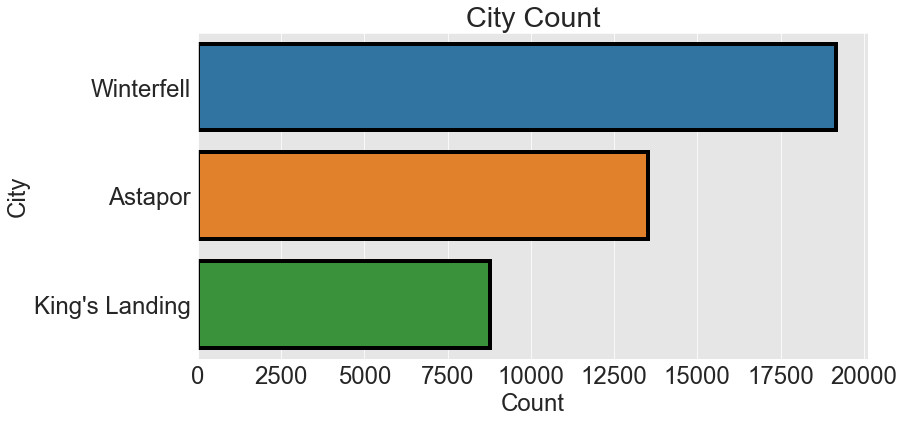

In [18]:
count_plot("city")

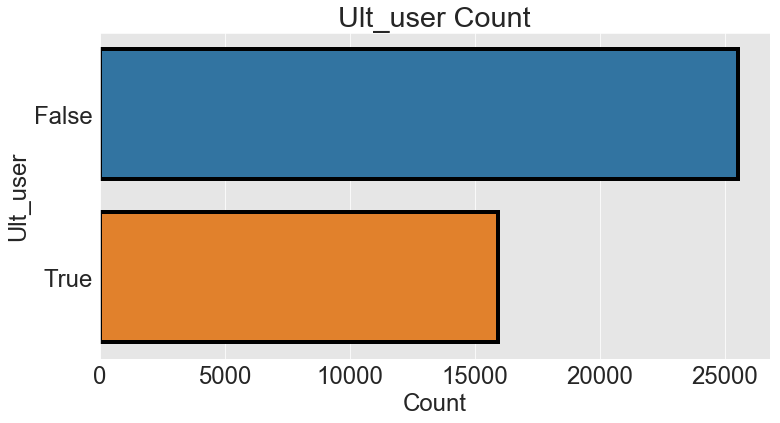

In [19]:
count_plot("ult_user")

# visualize continuous features

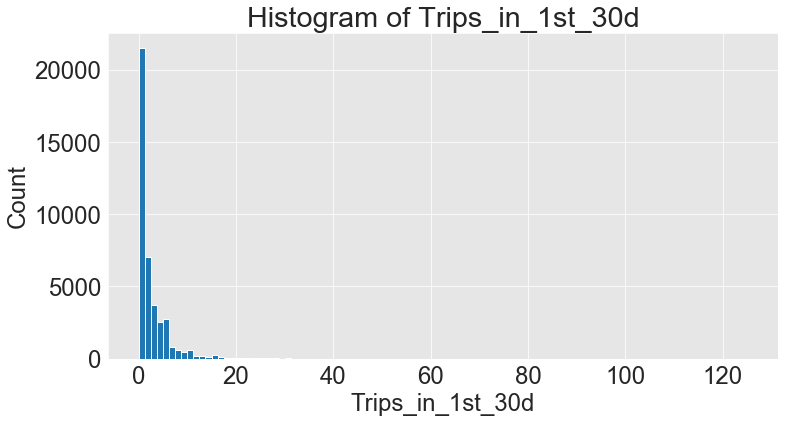

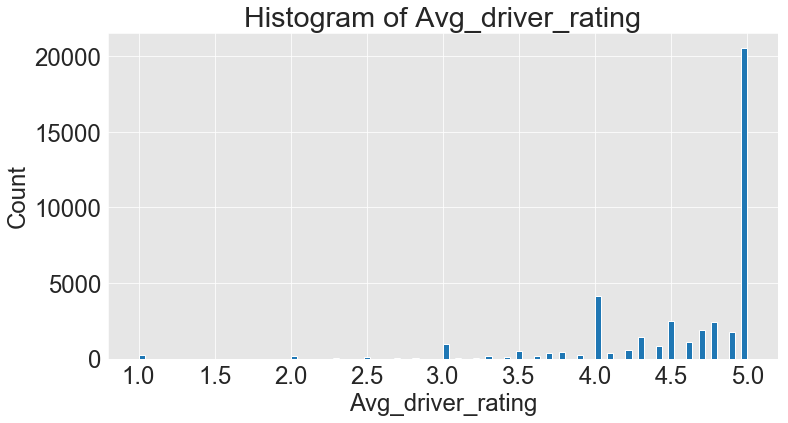

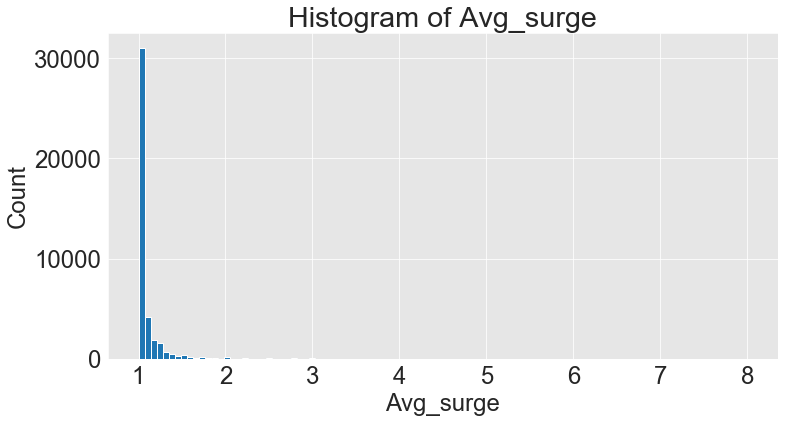

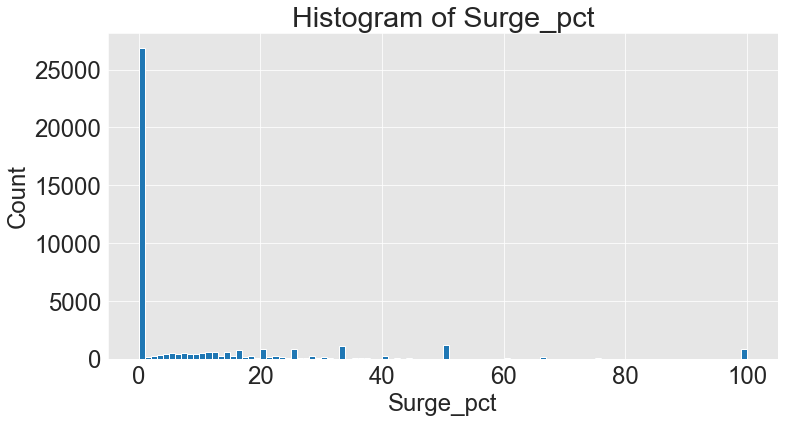

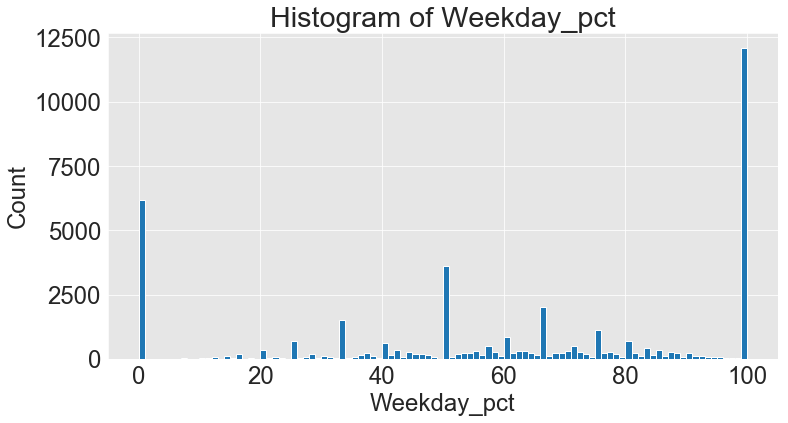

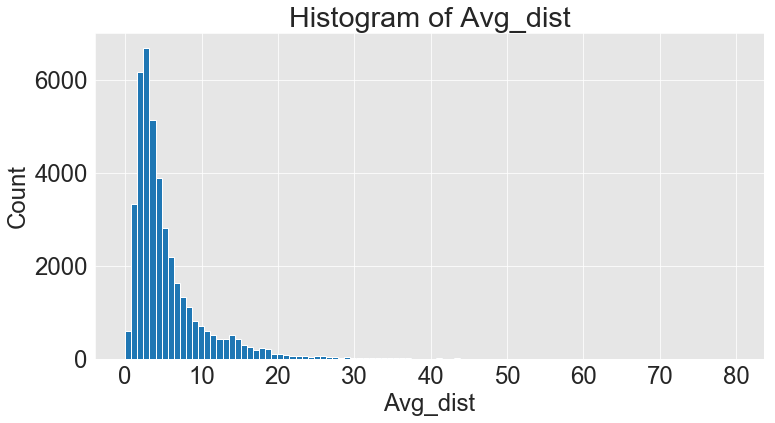

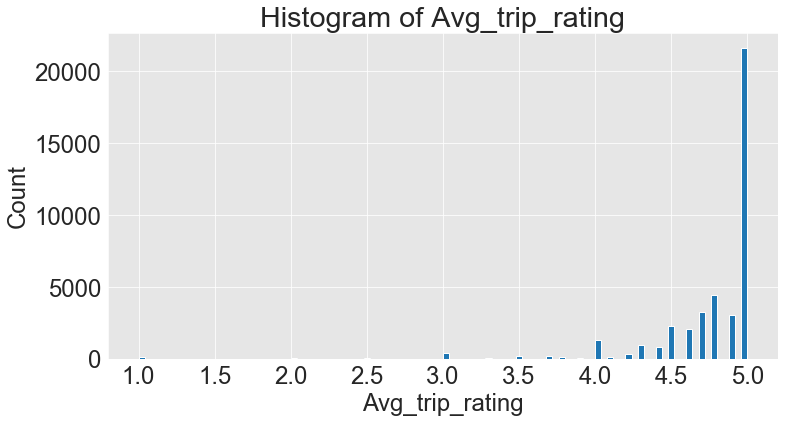

In [20]:
for column in df.columns[5:-2]:
    df.hist(column, bins = 100)
    plt.title("Histogram of " + column.capitalize())
    plt.xlabel(column.capitalize())
    plt.ylabel("Count")
    plt.show()

# Cell below this is a class I created for Binary Classification problems

# Example Use:

### models = Binary_Classification(x, y, standardize = True, scoring = "roc_auc")
takes in x and y, standarizes all continuous columns, performs train_test_split (test_size = 0.3), and performs GridSearchCV on train (n_folds = 5); the metric to evaluate models against will be roc_auc in this case

### models.compare()
will compare several models against one another and compute best parameters for each model

models compared: logistic regression, k-nearest neighbor, gaussian naive bayes, multi nomial naive bayes, random forest, and if desired xtreme gradient boosting (usually takes more than 5 minutes to run so it has been commented out)

### models.test_scores("ran_for", verbose_results = False)
will compute f1, accuracy, and roc_auc score for training and test data using model given (in this case using random forest); verbose_results set to True will generate more details of the results

### models.permutation_importance("ran_for")
will determine which features are most important to the model. "The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled." (https://scikit-learn.org/dev/modules/permutation_importance.html) Permutation importances is computed on the held-out validation set, because "a held-out set makes it possible to highlight which features contribute the most to the generalization power of the inspected model. Features that are important on the training set but not on the held-out set might cause the model to overfit." (same source)

see also: https://www.kaggle.com/dansbecker/permutation-importance

In [21]:
class Binary_Classification:
    def __init__(self, 
                 x, 
                 y, 
                 scoring = None, 
                 test_size = 0.3, 
                 n_folds = 5, 
                 standardize = False): 
        
        self.x = x # features as df
        self.y = y # target as df
        self.scoring = scoring # example: "accuracy", "f1", "roc_auc"
        self.test_size = test_size # set to .3 by default
        self.n_folds = n_folds # set to 5 by default
        self.standardize = standardize
        self.x_train, self.x_test, self.y_train, self.y_test = \
        train_test_split(self.x, 
                         self.y, 
                         train_size = self.test_size, 
                         random_state = 0)
    
    """ 
    .examine_model attribute has two functions within it:
    (1) model_and_grid => using a model's name, it returns the model with cvgrid
    (2) best_model => using model_and_grid, finds best hyperparameters for model
    """
    
    def examine_model(self, model_name):
        
        def model_and_grid(model_name):
            if model_name == "log_reg":
                model = LogisticRegression()
                grid = {'C' : [0.001, 0.1, 1, 10, 100]}
                return model, grid

            elif model_name == "knn":
                model = KNeighborsClassifier()
                grid = {"n_neighbors" : [3,6,9,12]}
                return model, grid
            
            elif model_name == "gnb":
                model = GaussianNB()
                grid = {"var_smoothing" : [1e-01, 1e-05, 1e-09, 1e-15]}
                return model, grid
            
            elif model_name == "mnb":
                model = MultinomialNB()
                grid = {"alpha" : [.1, 1, 5, 10, 50]}
                return model, grid
            
            elif model_name == "ran_for":
                model = RandomForestClassifier(random_state=0)
                grid = {'n_estimators' : [1, 30], 
                        'max_features' : ['auto', 'log2'],  
                        'max_depth' : [ 3, 5, 7, 10, 12, 15], 
                        'criterion' : ['gini', 'entropy']}
                return model, grid

            elif model_name == "xgb":
                model = XGBClassifier()
                grid = { 
                          "max_depth"         : [2, 4, 8, 16],
                          "alpha"             : [10, 20, 30],
                          "lambda"            : [10, 20, 30],
        #                  "min_child_weight" : [  1,  5],
        #                  "colsample_bytree" : [ .3, .7],
        #                  "learning_rate"    : [.10, .30],
        #                  "gamma"            : [  0, .5, 5],
        #                  "eta"              : [0.05, 0.20]
                }  
                return model, grid
        
        def best_model(model, grid):
            gs = GridSearchCV(model, param_grid=grid, cv=self.n_folds, scoring=self.scoring)
            gs.fit(self.x_train, self.y_train.iloc[:,0])
            print("CV " + self.scoring.upper() + " SCORE:", round(gs.best_score_,3))
            print("CV PARAMS: ", gs.best_params_)
            #print("BEST MODEL: ", gs.best_estimator_)
            best_model = gs.best_estimator_
            return best_model

        model, grid = model_and_grid(model_name)
        best_mod = best_model(model, grid)
        return best_mod

    """ 
    .compare attribute uses examine_model to compare all models
    """
    
    def compare(self):
        z = 0
        mods = ["log_reg", 
                "knn", 
                "gnb", 
                "mnb", 
                "ran_for",
                #"xgb"
               ]
        for name in mods:
            print("*** " + mods[z] + " ***")
            self.examine_model(name)
            print("")
            z += 1
    
    """ 
    .test_scores attribute uses examine_model to report various metrics on training & test data
    """
    
    def test_scores(self, model_name, verbose_results=False, all_metrics=True, show_test=True): 
        model = self.examine_model(model_name)
        y_pred_train = model.predict(self.x_train)
        y_pred_test = model.predict(self.x_test)
        y_prob_train = model.predict_proba(self.x_train)[:,1]
        y_prob_test = model.predict_proba(self.x_test)[:,1]

        """ F1 (f-one) Score """
        ## F1 Score = 2*((precision*recall)/(precision+recall))
        if self.scoring == "f1" or all_metrics:
            f1_train = metrics.f1_score(self.y_train.iloc[:,0], y_pred_train)
            print("\nF1 on training data:{:0.2f}".format(f1_train))

            if show_test:
                f1_test = metrics.f1_score(self.y_test.iloc[:,0], y_pred_test)
                print("F1 on test data:{:0.2f}".format(f1_test))
                print()

        """ Accuracy """
        ## number of correct predictions made / total number of predictions made
        ### accuracy is not a good metric for imbalanced data
        if self.scoring == "accuracy" or all_metrics:
            accuracy_training = model.score(self.x_train, self.y_train)
            tru_count_train = Counter(self.y_train.iloc[:,0])[True]
            fal_count_train = Counter(self.y_train.iloc[:,0])[False]

            # test baseline
            print("chance of true in training (baseline): ", 
                  round(tru_count_train/(tru_count_train + fal_count_train),2))
            print("chance of false in training (baseline): ", 
                  round(fal_count_train/(tru_count_train + fal_count_train),2))
            
            print("Accuracy on training data: {:0.2f}".format(accuracy_training))
            print()

            if show_test:
                accuracy_test = model.score(self.x_test, self.y_test)
                tru_count_test = Counter(self.y_test.iloc[:,0])[True]
                fal_count_test = Counter(self.y_test.iloc[:,0])[False]

                # test baseline
                print("chance of true in test (baseline): ", 
                      round(tru_count_test/(tru_count_test + fal_count_test),2))
                print("chance of false in test (baseline): ", 
                      round(fal_count_test/(tru_count_test + fal_count_test),2))
                
                print("Accuracy on test data:  {:0.2f}".format(accuracy_test))
                print()

        """ ROC AUC """
        ## How well model distinguishs between classes
        ### Higher the AUC, better the model is at predicting 0 as 0 and 1 as 1
        #### https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
        if self.scoring == "roc_auc" or all_metrics:
            roc_auc_score_training = roc_auc_score(self.y_train.iloc[:,0], y_prob_train)
            print("ROC AUC on training data:{:0.2f}".format(roc_auc_score_training))

            if show_test:
                roc_auc_score_test = roc_auc_score(self.y_test.iloc[:,0], y_prob_test)
                print("ROC AUC on test data:{:0.2f}\n".format(roc_auc_score_test))

            if not show_test:
                print()

        """ Classification Report """
        ## Precision = TP / TP + FP
        ### Also known as Positive Predictive Value
        ## Recall = TP/ TP + FN
        class_repo = classification_report(self.y_test,y_pred_test)
        print("\nClassification Report on test data:\n", class_repo)

        try:
            # Coefficients
            coefs = pd.Series(model.coef_[0], index=self.x.columns)
            coefs = coefs.sort_values()
            coefs.plot(kind="bar",title="Coefficients")
            #plt.xticks(fontsize=20)
            #plt.yticks(fontsize=20)
            plt.show()
            #print(coefs.sort_values(ascending = False))
        except: 
            print("No coefficients need to be fitted by optimization procedure")
            
        """ Confusion matrix """
        def print_confusion_matrix(confusion_matrix, 
                           class_names,
                           #figsize = (2,2), fontsize=20
                          ):
    
            """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
            2 benefits: (1) mieruka (i.e., visual control) and 
            (2) colors change depending on values (larger values generate darker colors)
            
            if you're wondering what mieruka is: 
            https://harishsnotebook.wordpress.com/2016/05/05/visibilization-crime-fighting-magic-and-mieruka/

            Arguments
            ---------
            confusion_matrix: numpy.ndarray
                The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
                Similarly constructed ndarrays can also be used.
            class_names: list
                An ordered list of class names, in the order they index the given confusion matrix.
            figsize: tuple
                A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
                the second determining the vertical size. Defaults to (10,7).
            fontsize: int
                Font size for axes labels. Defaults to 14.

            Returns
            -------
            matplotlib.figure.Figure
                The resulting confusion matrix figure
            """

            df_cm = pd.DataFrame(
                confusion_matrix, 
                index=class_names, 
                columns=class_names, 
            )

            fig = plt.figure(#figsize=figsize
            )

            try:
                heatmap = sns.heatmap(df_cm, 
                                      annot=True, 
                                      fmt="d", 
                                      cbar=False, 
                                      cmap="YlGnBu")
            except ValueError:
                raise ValueError("Confusion matrix values must be integers.")

                heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), 
                                             rotation=0, 
                                             ha='right', 
                                             #fontsize=fontsize
                                            )

                heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), 
                                             rotation=45, 
                                             ha='right', 
                                             #fontsize=fontsize
                                            )

            plt.title('Confusion Matrix')
            plt.ylabel('Correct label')
            plt.xlabel('Predicted label')
            
        c_matrix = confusion_matrix(self.y_test, y_pred_test)
        print_confusion_matrix(c_matrix, [False, True])
        
        if verbose_results:
            #Plot ROC curve
            fpr, tpr, thresholds = roc_curve(self.y_test, y_prob_test)
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr, tpr)
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.show()
            print("")    
                
            # Threshold Plot
            precision, recall, thresholds = precision_recall_curve(self.y_test, y_prob_test)
            f1 = []
            acc = []
            roc = []
            avg_pr = []

            def adjust_pred_prob(y_prob_test, new_threshold):
                return [1 if prob >= new_threshold else 0 for prob in y_prob_test]

            for t in thresholds:
                adjusted_y_pred = adjust_pred_prob(y_prob_test, t)
                add_f1 = metrics.f1_score(self.y_test, adjusted_y_pred)
                f1.append(add_f1)
                
            for t in thresholds:
                adjusted_y_pred = adjust_pred_prob(y_prob_test, t)
                add_acc = accuracy_score(self.y_test, adjusted_y_pred)
                acc.append(add_acc)
                
            for t in thresholds:
                adjusted_y_pred = adjust_pred_prob(y_prob_test, t)
                add_avg_pr = average_precision_score(self.y_test, adjusted_y_pred)
                avg_pr.append(add_avg_pr)
                
#             ## Retrieve probability of being 1(in second column of probs_y)
#             pr_auc = metrics.auc(recall, precision)

            plt.title("Precision-Recall-Accuracy vs Threshold")
            plt.plot(thresholds, precision[: -1], "b-", label="Precision")
            plt.plot(thresholds, recall[: -1], "r-", label="Recall")
            #plt.plot(thresholds, avg_pr, "k-", label="Average Precision Recall")
            #plt.plot(thresholds, f1, "k-", label="F1_Score")
            plt.plot(thresholds, acc, "g-", label="Accuracy")
            
            max_acc_x = thresholds[np.argmax(acc)]
            plt.axvline(x=max_acc_x, ymin=0.00, ymax=max(acc), color='g', linestyle='-')
            #plt.axhline(y=max(acc), color='g', linestyle='--')
            #plt.text(max_acc_x, max(acc), ("Max Accuracy " + str(round(max_acc_x,2))), rotation=90)
            
            #max_f1_x = thresholds[np.argmax(f1)]
            #plt.axvline(x=max_f1_x, color='k', linestyle='--')
            #plt.axhline(y=max(f1), color='k', linestyle='--')
            #plt.text(max_f1_x, max(f1), ("Max F1 Score " + str(round(max_f1_x,2))), rotation=90)
                        
            plt.ylabel("Score")
            plt.xlabel("Threshold")
            
            #plt.text(intersect_x, intersect_y, 'PR Intersect', rotation=90)
            plt.legend(loc="lower left")
            plt.ylim([0,1])
            plt.show()
            print("Maximum Accuracy: " + str(round(max(acc),2)) + " @ Threshold: " + str(round(max_acc_x,2)))
            #print("Maximum F1 Score: " + str(round(max(f1),2)) + " @ Threshold: " + str(round(max_f1_x,2)))
            
            """ 
            Varying Fscore's beta vs Varying Thresholds
            
            The beta parameter determines the weight of recall in the combined score. 
            beta < 1 lends more weight to precision, while 
            beta > 1 favors recall 
            (beta -> 0 considers only precision, beta -> inf only recall).
            """

            f025 = []
            f050 = []
            f075 = []
            f100 = []
            f125 = []
            f150 = []
            f200 = []

            def fbeta_testing(beta, fxxx):
                for t in thresholds:
                    adjusted_y_pred = adjust_pred_prob(y_prob_test, t)
                    add_fbeta = metrics.fbeta_score(self.y_test, adjusted_y_pred, beta)
                    fxxx.append(add_fbeta)

            betas = [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 2.00]
            flist = [f025, f050, f075, f100, f125, f150, f200]

            z = 0
            for beta in betas:
                fbeta_testing(beta, flist[z])
                z += 1

            plt.title("F_Beta_Score vs Threshold: Varying Betas")
            #plt.plot(thresholds, f025, "r-", label="F0.25")
            plt.plot(thresholds, f050, "m-", label="F0.50")
            #plt.plot(thresholds, f075, "g-", label="F0.75")
            plt.plot(thresholds, f100, "c-", label="F1.00")
            #plt.plot(thresholds, f125, "b-", label="F1.25")
            #plt.plot(thresholds, f150, "k-", label="F1.50")
            plt.plot(thresholds, f200, "y-", label="F2.00")
            #plt.axvline(.425, color='k', linestyle='--')
            #plt.axvline(.45, color='k', linestyle='-')
            
            max_f050_x = thresholds[np.argmax(f050)]
            plt.axvline(x=max_f050_x, ymin=0.00, ymax=max(f050), color='m', linestyle='-')
            max_f100_x = thresholds[np.argmax(f100)]
            plt.axvline(x=max_f100_x,ymin=0.00, ymax=max(f100), color='c', linestyle='-')
            max_f200_x = thresholds[np.argmax(f200)]
            plt.axvline(x=max_f200_x, ymin=0.00, ymax=max(f200), color='y', linestyle='-')
            
            plt.ylabel("F_Beta_Score")
            plt.xlabel("Threshold")
            plt.legend(loc="lower left")
            plt.ylim([0,1])
            plt.show()
            
            print("Maximum F0.5 Score: " + str(round(max(f050),2)) + " @ Threshold: " + str(round(max_f050_x,2)))
            print("Maximum F1   Score: " + str(round(max(f100),2)) + " @ Threshold: " + str(round(max_f100_x,2)))
            print("Maximum F2.0 Score: " + str(round(max(f200),2)) + " @ Threshold: " + str(round(max_f200_x,2)))

            """ Threshold = 0.5, varying fscore's beta """

            betas = [0.25,0.50,0.75,1.00,1.25,1.50,2.00]
            fbetas = []

            for beta in betas:
                score = fbeta_score(self.y_test, y_pred_test, beta=beta)
                fbetas.append(score)
        
    def feature_importance(self, model_name): 
        model = self.examine_model(model_name)
        fitted = model.fit(self.x_train, self.y_train.iloc[:,0])
        
        importances = fitted.feature_importances_
        indices = np.argsort(importances)
        features = self.x_train.columns
        plt.title('Feature Importances')
        plt.barh(range(len(indices)), importances[indices], color='grey', align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.ylabel('Features')
        plt.show()
    
    """ 
    .permutation_importance attribute uses examine_model to report features in order of importance
    """
    def permutation_importance(self, model_name): 
        # https://www.kaggle.com/dansbecker/permutation-importance
        model = self.examine_model(model_name)
        fitted = model.fit(self.x_train, self.y_train.iloc[:,0])
        
        perm = PermutationImportance(fitted, random_state=0).fit(self.x_test, self.y_test.iloc[:,0])
        return eli5.show_weights(perm, feature_names = self.x_test.columns.tolist())
    
    def shap_summary_plot(self, model_name): 
        """Calculating SHAP values can be slow"""
        # https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values
        
        model = self.examine_model(model_name)
        fitted = model.fit(self.x_train, self.y_train.iloc[:,0])
        
        if model_name == "ran_for":
            explainer = shap.TreeExplainer(fitted)
            shap_values = explainer.shap_values(self.x_test)
            # we index in ([1]) to get the SHAP values for the prediction of "True"
            return shap.summary_plot(shap_values[1], self.x_test)
        
        else:     
            """ KernelExplainer cannot handle boolean values, they must be converted to int """
            x_train_summary = shap.kmeans(self.x_train, 3)
            explainer = shap.KernelExplainer(fitted.predict, x_train_summary)
            shap_values = explainer.shap_values(self.x_test)
            return shap.summary_plot(shap_values, self.x_test)
    
    def coefficients(self, model_name):
        model = self.examine_model(model_name)
        try:
            # Coefficients
            coefs = pd.Series(model.coef_[0], index = self.x.columns)
            coefs = coefs.sort_values()
            coefs.plot(kind="bar",title=(model_name.capitalize() + " Coefficients"))
            plt.show()
        except: 
            print("No coefficients need to be fitted by optimization procedure")

In [22]:
# create dummies for categorical variables
# we exclude the date columns as "last_trip_date" is a version of the target variable and 
# signup_date is limited to the month of january

df[["ult_user"]] *= 1 # convert to int since SHAP does not accept boolean values in KernelExplainer
dummies = pd.get_dummies(df[['city', "phone"]])
continuous_vars = df.iloc[:,4:-2]

x = pd.concat([dummies, continuous_vars], axis = 1)
y = df[['retained']] 
# y is kept as a dataframe for the graphics made by my class; it is transformed into a series when called for ML

# check x is correct
x.head(3)

,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ult_user,trips_in_1st_30d,avg_driver_rating,avg_surge,surge_pct,weekday_pct,avg_dist,avg_trip_rating
0,0,1,0,0,1,1,4,4.7,1.1,15.4,46.2,3.67,5.0
1,1,0,0,1,0,0,0,5.0,1.0,0.0,50.0,8.26,5.0
2,1,0,0,0,1,0,3,4.3,1.0,0.0,100.0,0.77,5.0


In [23]:
models = Binary_Classification(x, y, standardize = True, scoring = "roc_auc")
# we use roc_auc as the optimization metric because it is independent of threshold
# f1 would be better if we were dealing with 
# highly imbalanced data (90-99% False : 1-10% True), 
# but our data is 60% false : 40% true

models.compare()

*** log_reg ***
CV ROC_AUC SCORE: 0.761
CV PARAMS:  {'C': 1}

*** knn ***
CV ROC_AUC SCORE: 0.794
CV PARAMS:  {'n_neighbors': 12}

*** gnb ***
CV ROC_AUC SCORE: 0.771
CV PARAMS:  {'var_smoothing': 1e-05}

*** mnb ***
CV ROC_AUC SCORE: 0.691
CV PARAMS:  {'alpha': 0.1}

*** ran_for ***
CV ROC_AUC SCORE: 0.845
CV PARAMS:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 30}



CV ROC_AUC SCORE: 0.845
CV PARAMS:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 30}

F1 on training data:0.78
F1 on test data:0.71

chance of true in training (baseline):  0.41
chance of false in training (baseline):  0.59
Accuracy on training data: 0.83

chance of true in test (baseline):  0.41
chance of false in test (baseline):  0.59
Accuracy on test data:  0.77

ROC AUC on training data:0.91
ROC AUC on test data:0.84


Classification Report on test data:
               precision    recall  f1-score   support

       False       0.79      0.83      0.81     17028
        True       0.74      0.69      0.71     11984

   micro avg       0.77      0.77      0.77     29012
   macro avg       0.76      0.76      0.76     29012
weighted avg       0.77      0.77      0.77     29012

No coefficients need to be fitted by optimization procedure


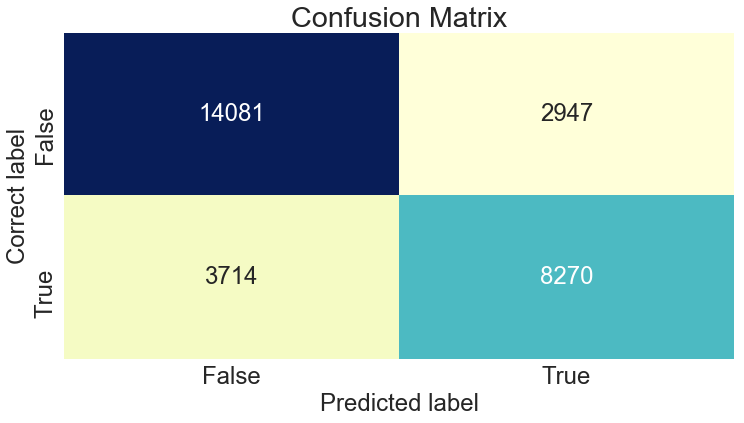

In [24]:
# random forest gives the highest cross-validation scores; let's see its ability to generalize
models.test_scores("ran_for")

CV ROC_AUC SCORE: 0.845
CV PARAMS:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 30}


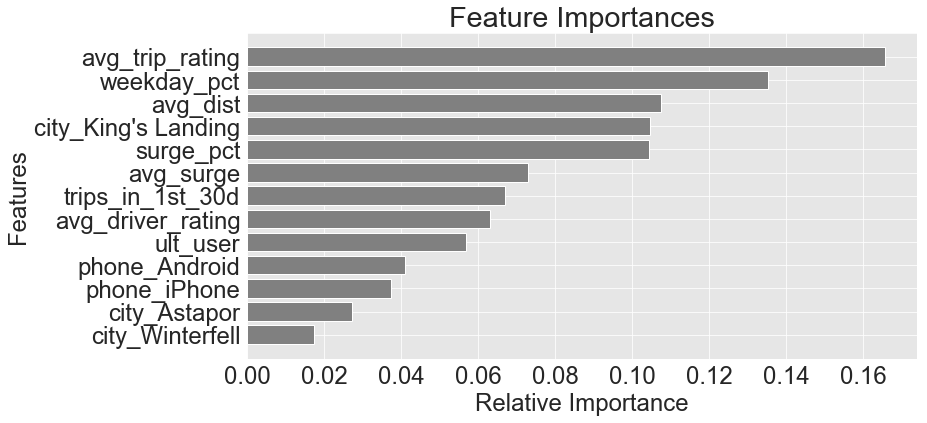

In [25]:
models.feature_importance("ran_for")

In [26]:
models.permutation_importance("ran_for")

CV ROC_AUC SCORE: 0.845
CV PARAMS:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 30}


Weight,Feature
0.0398 ± 0.0019,city_King's Landing
0.0327 ± 0.0019,avg_trip_rating
0.0220 ± 0.0029,weekday_pct
0.0159 ± 0.0026,ult_user
0.0108 ± 0.0010,surge_pct
0.0064 ± 0.0016,phone_iPhone
0.0059 ± 0.0010,avg_surge
0.0051 ± 0.0018,trips_in_1st_30d
0.0050 ± 0.0014,phone_Android
0.0040 ± 0.0021,city_Astapor


# For Random Forests, the top five most important features for predicting retention were trips to King's Landing, Average Trip Rating, Weekday Percentage, if rider was an Ultimate Black User, and Average Surge.

# To understand how each feature affects retention, we need to look at the shap summary plot

CV ROC_AUC SCORE: 0.845
CV PARAMS:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 30}


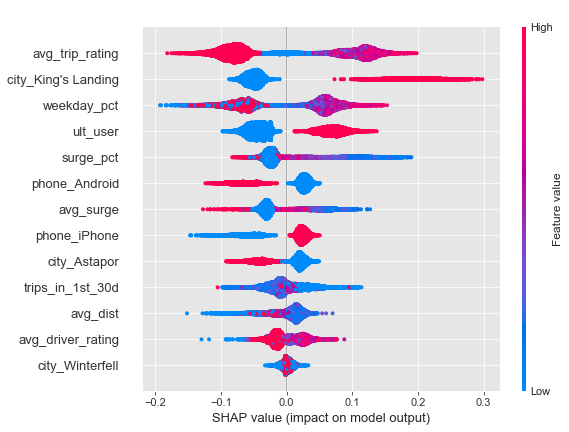

In [27]:
models.shap_summary_plot("ran_for")

# SHAP value > 0 == positively affect retention

# Color == feature's value (red being the highest value)

# For binary values, there is only red (1) and blue (0).

### Average Trip Rating: ambiguous as high ratings both negatively and positively affect model
### Going to King's Landing: ↑ retention
### Weekday Percentage: ambiguous
### if rider was an Ultimate Black User: ↑ retention
### Average Surge: ambiguous

# Next, let's examine Logistic Regression's coefficients, permutation importance, and shap values to see why it did not do as well as the random forest

CV ROC_AUC SCORE: 0.761
CV PARAMS:  {'C': 1}


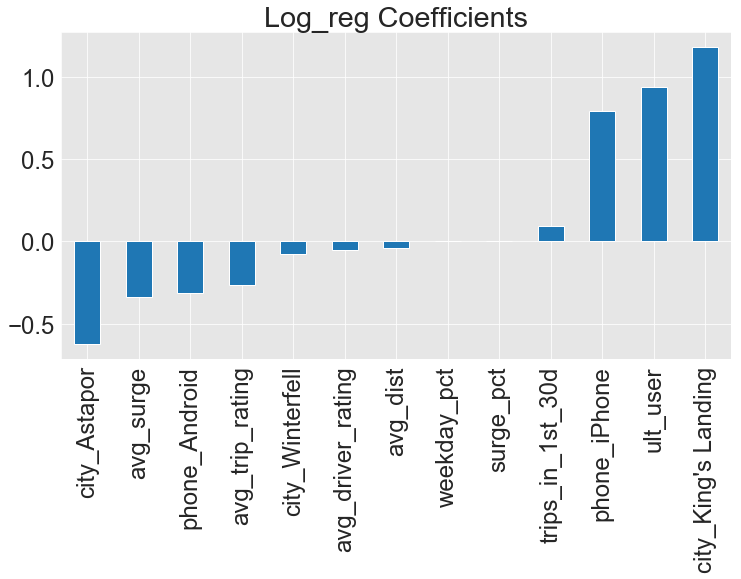

In [28]:
# let's check logistic regression's coefficients
models.coefficients("log_reg")

# Similar to Random Forest:
## Positively affect retention: King's Landing & if rider was an Ultimate Black User

In [29]:
models.permutation_importance("log_reg")

CV ROC_AUC SCORE: 0.761
CV PARAMS:  {'C': 1}


Weight,Feature
0.0391 ± 0.0022,city_King's Landing
0.0363 ± 0.0041,ult_user
0.0218 ± 0.0023,trips_in_1st_30d
0.0170 ± 0.0021,phone_iPhone
0.0136 ± 0.0038,city_Astapor
0.0052 ± 0.0011,avg_dist
0.0019 ± 0.0012,phone_Android
0.0012 ± 0.0015,surge_pct
0.0002 ± 0.0008,avg_trip_rating
0.0000 ± 0.0007,avg_driver_rating


CV ROC_AUC SCORE: 0.761
CV PARAMS:  {'C': 1}


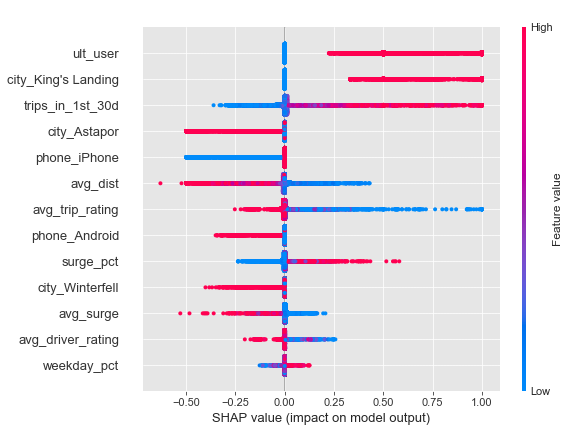

In [30]:
# non-tree models take about 10 minutes for graphic
models.shap_summary_plot("log_reg")

# Finally we'll check if any features are over 50% correlated; removing highly correlated features may improve the model's ability to predict

In [31]:
""" For checking which features are most correlated """

def get_redundant_pairs(df):
    # Get diagonal and lower triangular pairs of correlation matrix
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def over_50perc_corr(df):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    tops = au_corr[au_corr > 0.50] 
    return tops

In [32]:
corr_df = pd.concat([x,y], axis=1)

over_50perc_corr(corr_df)

phone_Android  phone_iPhone       1.000000
avg_surge      surge_pct          0.795737
city_Astapor   city_Winterfell    0.644825
dtype: float64

# Let's remove android, surge_pct, city_Winterfell. 
### Android is removed arbitrarily
### Surge_pct and Winterfell were consistently less valuable for the models; they will be removed

In [33]:
x2 = x.drop(["phone_Android", "surge_pct", "city_Winterfell"], axis = 1)
x2.head(3)

,city_Astapor,city_King's Landing,phone_iPhone,ult_user,trips_in_1st_30d,avg_driver_rating,avg_surge,weekday_pct,avg_dist,avg_trip_rating
0,0,1,1,1,4,4.7,1.1,46.2,3.67,5.0
1,1,0,0,0,0,5.0,1.0,50.0,8.26,5.0
2,1,0,1,0,3,4.3,1.0,100.0,0.77,5.0


In [34]:
models_02 = Binary_Classification(x2, y, standardize = True, scoring = "roc_auc")

models_02.compare()

*** log_reg ***
CV ROC_AUC SCORE: 0.761
CV PARAMS:  {'C': 0.1}

*** knn ***
CV ROC_AUC SCORE: 0.794
CV PARAMS:  {'n_neighbors': 12}

*** gnb ***
CV ROC_AUC SCORE: 0.774
CV PARAMS:  {'var_smoothing': 1e-05}

*** mnb ***
CV ROC_AUC SCORE: 0.676
CV PARAMS:  {'alpha': 0.1}

*** ran_for ***
CV ROC_AUC SCORE: 0.843
CV PARAMS:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 30}



CV ROC_AUC SCORE: 0.843
CV PARAMS:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 30}

F1 on training data:0.79
F1 on test data:0.71

chance of true in training (baseline):  0.41
chance of false in training (baseline):  0.59
Accuracy on training data: 0.83

chance of true in test (baseline):  0.41
chance of false in test (baseline):  0.59
Accuracy on test data:  0.77

ROC AUC on training data:0.91
ROC AUC on test data:0.84


Classification Report on test data:
               precision    recall  f1-score   support

       False       0.79      0.83      0.81     17028
        True       0.73      0.68      0.71     11984

   micro avg       0.77      0.77      0.77     29012
   macro avg       0.76      0.76      0.76     29012
weighted avg       0.77      0.77      0.77     29012

No coefficients need to be fitted by optimization procedure


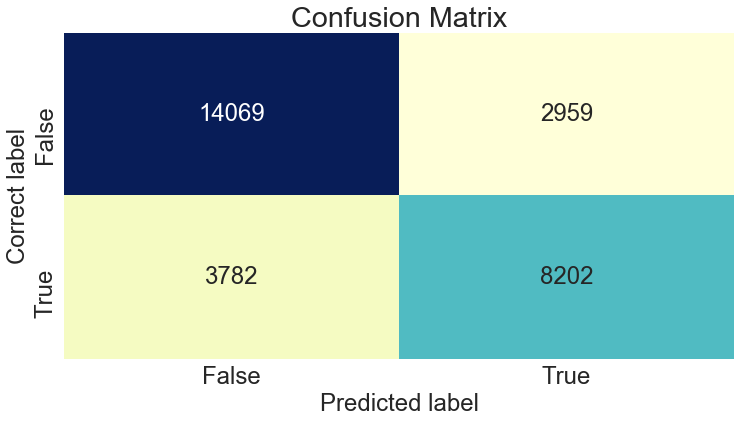

In [35]:
models_02.test_scores("ran_for")

# Removal of redundant features did not improve the model's ability to predict retention